In [43]:
import tensorflow
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# import tensorflow
import cv2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
import itertools
import keras.layers


In [44]:
train_generator=image_dataset_from_directory(directory=r"C:\Users\Acer\Downloads\Brain%20Tumor\Training",
                                            image_size=(256,256))
test_generator=image_dataset_from_directory(directory=r"C:\Users\Acer\Downloads\Brain%20Tumor\Testing",
                                            image_size=(256,256))
rescale=Rescaling(scale=1/255)
train_generator=train_generator.map(lambda image,label:(rescale(image),label) )
test_generator=test_generator.map(lambda image,label:(rescale(image),label) )

Found 13196 files belonging to 4 classes.
Found 1683 files belonging to 4 classes.


In [45]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(256,256,3)))
model.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D(3,3))

model.add(Flatten())

model.add(Dense(1568,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(4,activation="softmax"))


In [46]:
# model=Sequential()
# model.add(Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(256,256,3)))
# model.add(MaxPooling2D(3,3))

# model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
# model.add(MaxPooling2D(3,3))

# model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
# model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
# model.add(MaxPooling2D(3,3))

# model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
# model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
# model.add(MaxPooling2D(3,3))

# model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
# model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
# model.add(MaxPooling2D(3,3))

# model.add(Flatten())

# model.add(Dense(1568,activation="relu"))
# model.add(Dropout(0.3))

# model.add(Dense(4,activation="softmax"))


In [47]:
data_augmentation=Sequential([
    keras.layers.RandomRotation(0.5),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.2),
    keras.layers.CenterCrop(256,256)
])
train_generator=train_generator.map(lambda x,y: (data_augmentation(x,training=True),y))
model.compile(optimizer=Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_35 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 85, 85, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 85, 85, 64)        18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 85, 85, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 28, 28, 64)        0         
 ng2D)                                               

In [48]:
# callbacks=[
#     ReduceLROnPlateau(
#         monitor="val_loss",
#         factor=0.3,
#         patience=3,
#         min_lr=1e-6,
#         verbose=1
#     ),
#     EarlyStopping(
#         monitor="val_loss",
#         patience=3,
#         restore_best_weights=True,
#         verbose=1
#     )
# ]

In [49]:
history=model.fit(train_generator,validation_data=test_generator,epochs=20)

Epoch 1/20
413/413 [==============================] - 991s 2s/step - loss: 1.1345 - accuracy: 0.4921 - val_loss: 1.1554 - val_accuracy: 0.5021
Epoch 2/20
413/413 [==============================] - 1053s 3s/step - loss: 0.9337 - accuracy: 0.5959 - val_loss: 0.8322 - val_accuracy: 0.6958
Epoch 3/20
413/413 [==============================] - 825s 2s/step - loss: 0.7791 - accuracy: 0.6595 - val_loss: 0.7074 - val_accuracy: 0.7207
Epoch 4/20
413/413 [==============================] - 777s 2s/step - loss: 0.6823 - accuracy: 0.6970 - val_loss: 0.5946 - val_accuracy: 0.7802
Epoch 5/20
413/413 [==============================] - 784s 2s/step - loss: 0.6268 - accuracy: 0.7208 - val_loss: 0.5099 - val_accuracy: 0.8140
Epoch 6/20
413/413 [==============================] - 769s 2s/step - loss: 0.5911 - accuracy: 0.7359 - val_loss: 0.4288 - val_accuracy: 0.8622
Epoch 7/20
413/413 [==============================] - 761s 2s/step - loss: 0.5581 - accuracy: 0.7508 - val_loss: 0.4386 - val_accuracy: 0.825

C:\Users\Acer\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Acer\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


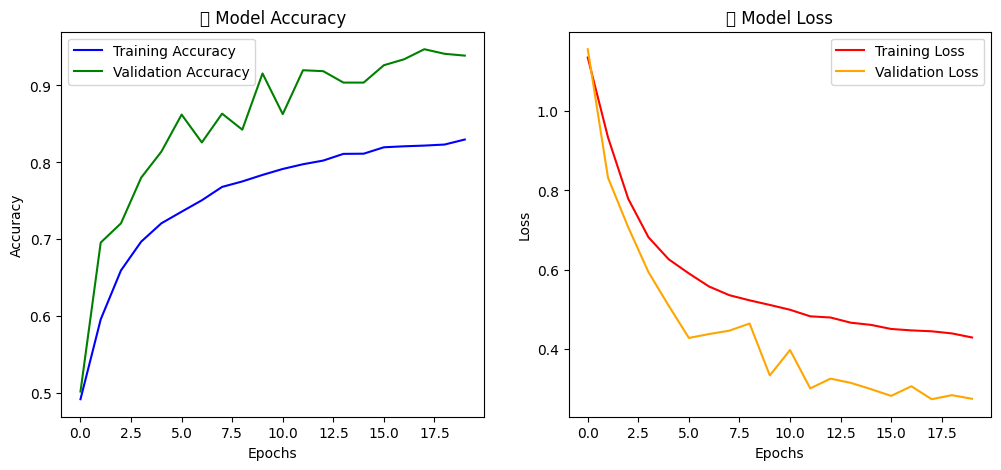

In [50]:

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('📈 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('📉 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [51]:
labels = []
predictions = []
for x,y in test_generator:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

1/1 [==============================] - 0s 453ms/step
Train Accuracy  : 82.97 %
Test Accuracy   : 93.88 %
Precision Score : 93.88 %
Recall Score    : 93.88 %


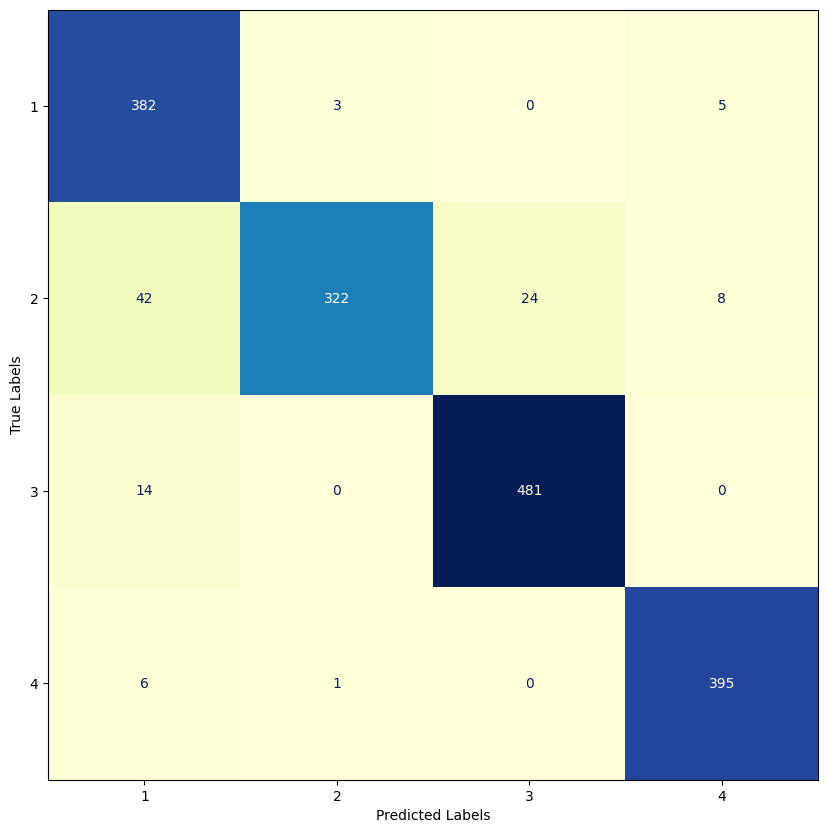

In [52]:
cm=confusion_matrix(labels,predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=(list(range(1,5))))
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax, colorbar=False, cmap='YlGnBu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [53]:
# classify=classification_report(y_true,y_pred_class,target_names=class_names)
# print(classify)

In [54]:
model.save("brain_cancer_model.h5")
model.save("brain_cancer_model.keras")

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
from tensorflow.keras.models import load_model

model = load_model("brain_cancer_model.h5")

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ✅ Load trained model
model = load_model("brain_cancer_model.h5")

# ✅ Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


# ✅ Load and preprocess MRI image
img_path = r"C:\Users\Acer\OneDrive\Documents\Datasets\tumor\Training\glioma\00001.png"
frame = cv2.imread(img_path)

if frame is None:
    raise FileNotFoundError("❌ Image not found. Check path!")

frame = cv2.resize(frame, (480, 480))
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# ✅ Apply proper threshold for contour detection
_, thress = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# ✅ Find contours

contours, _ = cv2.findContours(thress, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

detected_label = None
detected_conf = 0

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w * h < 500:  # Ignore small artifacts
        continue

    roi = frame[y:y + h, x:x + w]
    resized_roi = cv2.resize(roi, (256, 256))
    roi_array = img_to_array(resized_roi)
    roi_array = preprocess_input(roi_array)  # ✅ MobileNet normalization
    roi_array = np.expand_dims(roi_array, axis=0)

    # ✅ Predict tumor type
    prediction = model.predict(roi_array, verbose=0)
    class_id = np.argmax(prediction)
    class_label = class_names[class_id]
    confidence = prediction[0][class_id] * 100

    detected_label = class_label
    detected_conf = confidence

    # ✅ Draw bounding box + label on the frame
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
    cv2.putText(frame, f"{class_label} ({confidence:.2f}%)", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

# ✅ If no contour was detected (like "No Tumor" images)
if detected_label is None:
    # Predict directly on whole image
    img_resized = cv2.resize(frame, (256, 256))
    img_array = img_to_array(img_resized)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    class_id = np.argmax(prediction)
    detected_label = class_names[class_id]
    detected_conf = prediction[0][class_id] * 100

# ✅ Display image with prediction
plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(f"🧠 Brain Tumor Detection\nPrediction: {detected_label} ({detected_conf:.2f}%)", fontsize=14)
plt.axis("off")
plt.show()

# ✅ Print result in console too
print(f"🧩 Predicted Tumor Type: {detected_label}")
print(f"📊 Confidence: {detected_conf:.2f}%")


FileNotFoundError: ❌ Image not found. Check path!

In [ ]:
model.input_shape

(None, 256, 256, 3)